# Hyperparameter Tuning

In this notebook we will see how to use hyperparameter tuning for XGBoost model

## Read and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./Churn_modelling_processed_data.csv")

In [3]:
data.head(10)

,CreditScoreScaled,Germany,Spain,GenderCoded,AgeScaled,Tenure,BalanceScaled,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalaryScaled,Exited
0,0.538,0,0,0,0.324324,2,0.000000,1,1,1,0.506735,1
1,0.516,0,1,0,0.310811,1,0.334031,1,0,1,0.562709,0
2,0.304,0,0,0,0.324324,8,0.636357,3,1,0,0.569654,1
3,0.698,0,0,0,0.283784,1,0.000000,2,0,0,0.469120,0
4,1.000,0,1,0,0.337838,2,0.500246,1,1,1,0.395400,0
5,0.590,0,1,1,0.351351,8,0.453394,2,1,0,0.748797,1
6,0.944,0,0,1,0.432432,7,0.000000,2,1,1,0.050261,0
7,0.052,1,0,0,0.148649,4,0.458540,4,1,0,0.596733,1
8,0.302,0,0,1,0.351351,4,0.566170,2,0,1,0.374680,0
9,0.668,0,0,1,0.121622,2,0.536488,1,1,1,0.358605,0


In [16]:
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In this dataset '0' is majority (79.63%) and '1' is minority (20.37%). So we will not use accuracy as our metric. We will choose f1-score as our metric.

## Selecting X and y

In [4]:
features = data.columns.to_list()
features.pop()

features

['CreditScoreScaled',
 'Germany',
 'Spain',
 'GenderCoded',
 'AgeScaled',
 'Tenure',
 'BalanceScaled',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalaryScaled']

In [5]:
target = ['Exited']

In [6]:
X = data[features].values
y = data[target].values

In [7]:
X.shape

(10000, 11)

In [8]:
y.shape

(10000, 1)

## Split the dataset into train and test

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

In [11]:
X_train.shape

(8000, 11)

In [12]:
X_test.shape

(2000, 11)

## Creating a baseline (with default hyperparameter) XGBoost model

In [13]:
from xgboost import XGBClassifier

In [17]:
xgb_baseline = XGBClassifier()  # Initiate XGBoost classifier with default set of hyperparameters

In [18]:
xgb_baseline.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Train the baseline model

In [19]:
xgb_baseline = XGBClassifier(seed=0).fit(X_train, y_train)

### Evaluate the model performance on test dataset

In [23]:
y_pred_prob_baseline = xgb_baseline.predict_proba(X_test)[:,1]

In [25]:
y_pred_baseline = xgb_baseline.predict(X_test)

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [26]:
precision, recall, f1_score, support = score(y_test, y_pred_baseline)

In [29]:
print(f"Baseline model performance:\n----------------------------\nPrecision: {precision[1]:.3f}\nRecall: {recall[1]:.3f}\nf1_score: {f1_score[1]:.3f}")

Baseline model performance:
----------------------------
Precision: 0.754
Recall: 0.500
f1_score: 0.601


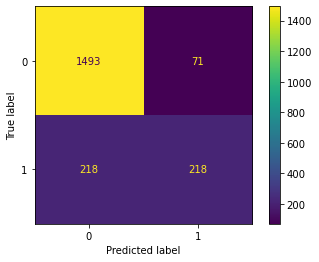

In [32]:
plot_confusion_matrix(estimator=xgb_baseline, X=X_test, y_true=y_test)

In [38]:
accuracy_score(y_true=y_test, y_pred=y_pred_baseline)

0.8555

## Use Grid Search to find optimum hyperparameter

In [45]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],  # number of estimators in the XGBoost model
    'colsample_bytree': [0.5, 0.75, 1.0],  # Percentage of columns to be randomly samples for each tree.
    'reg_alpha': [0, 0.5, 1, 5],           # reg_alpha provides l1 regularization to the weight 
    'reg_lambda': [0, 0.5, 1, 5]           # reg_alpha provides l2 regularization to the weight,
}

scoring = ['f1']

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
grid_search = GridSearchCV(estimator=XGBClassifier(),
                           param_grid=param_grid,
                           scoring=scoring,
                           refit='f1',
                           n_jobs=-1,
                           cv=3,
                           verbose=3)

In [53]:
grid_result = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


In [54]:
grid_result

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [55]:
print(f"The best score: {grid_result.best_score_:0.3f}")

The best score: 0.578


In [56]:
grid_result.best_params_

{'colsample_bytree': 0.5, 'n_estimators': 100, 'reg_alpha': 5, 'reg_lambda': 0}

In [57]:
grid_result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=5, reg_lambda=0, ...)

## Use Random Search to find optimum hyperparameters

In [58]:
from sklearn.model_selection import RandomizedSearchCV

In [62]:
random_search = RandomizedSearchCV(estimator=XGBClassifier(seed=0),
                                   param_distributions=param_grid,
                                   scoring=scoring,
                                   refit='f1',
                                   n_jobs=-1,
                                   cv=3,
                                   verbose=3,
                                   n_iter=50)

In [63]:
random_result = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [64]:
random_result

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [65]:
random_result.best_score_

0.5755146331971828

In [66]:
random_result.best_params_

{'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 100, 'colsample_bytree': 0.5}